## Data Collection and Feature Engineering steps

In [1]:
from IPython.display import clear_output
!pip install transformers[torch]
clear_output()

In [2]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer

def load_data(data_url):
    return pd.read_csv(data_url, sep='\t')

def preprocess_data(data):
    header = ["comment", "emotion", "id"]
    data.columns = header
    data = data[['comment', 'emotion']]
    data = data[data['emotion'].apply(lambda x: len(x.split(',')) == 1)]
    data['emotion'] = data['emotion'].apply(lambda x: ''.join(filter(str.isdigit, str(x)))).astype(int)
    return data

def sample_data(data, fraction=0.1):
    return data.groupby('emotion', group_keys=False).apply(lambda x: x.sample(frac=fraction)).reset_index(drop=True)

def tokenize_data(comments):
    # Tokenize using the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    return tokenizer(comments, padding=True, truncation=True, return_tensors='pt')

# URLs for train and validation data
train_data_url = 'https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/train.tsv'
validation_data_url = 'https://github.com/google-research/google-research/raw/master/goemotions/data/dev.tsv'

# Process train data
train_data = load_data(train_data_url)
train_data = preprocess_data(train_data)
sampled_train_data = sample_data(train_data)

# Process validation data
validation_data = load_data(validation_data_url)
validation_data = preprocess_data(validation_data)
sampled_validation_data = sample_data(validation_data)

# Tokenize the comments
train_tokenized_comments = tokenize_data(sampled_train_data['comment'].to_list())
validation_tokenized_comments = tokenize_data(sampled_validation_data['comment'].to_list())

# Prepare training data
X_train = train_tokenized_comments['input_ids']
attention_masks_train = train_tokenized_comments['attention_mask']
y_train = torch.tensor(sampled_train_data['emotion'].values)

# Prepare validation data
X_validation = validation_tokenized_comments['input_ids']
attention_masks_validation = validation_tokenized_comments['attention_mask']
y_validation = torch.tensor(sampled_validation_data['emotion'].values)

# Map the new labels to their original emotion names
emotions_dict = {
    0: "admiration", 1: "amusement", 2: "anger", 3: "annoyance", 4: "approval",
    5: "caring", 6: "confusion", 7: "curiosity", 8: "desire", 9: "disappointment",
    10: "disapproval", 11: "disgust", 12: "embarrassment", 13: "excitement", 14: "fear",
    15: "gratitude", 16: "grief", 17: "joy", 18: "love", 19: "nervousness",
    20: "optimism", 21: "pride", 22: "realization", 23: "relief", 24: "remorse",
    25: "sadness", 26: "surprise", 27: "neutral"
}

print()
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("y_train unique:", np.unique(y_train))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


X_train shape: torch.Size([3630, 46])
y_train shape: torch.Size([3630])
y_train unique: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


# 1. Model Building - ML Classifiers

We try classic ML Classifiers first.

Here's the current research question:

**"Can we predict the sentiment of a textual comment?"**

### Initialization

In [3]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

def print_device_info(device):
    print(f"Using device: {device}")
    if device.type == "cuda":
        print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
        print(f"CUDA memory allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    elif device.type == "mps":
        torch.mps.empty_cache()
        print(f"MPS memory allocated: {torch.mps.current_allocated_memory() / 1e9:.2f} GB")
    elif device.type == "cpu":
        print("No GPU available. Using CPU.")

device = get_device()
print_device_info(device)

Using device: cuda
CUDA Device: Tesla T4
CUDA memory allocated: 0.00 GB


### Define the model

In [4]:
from transformers import BertForSequenceClassification
# Load the BERT model
# we will use the bert-base-uncased model
# this model will classify the comments into 10 emotions

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=28)
model.to(device);  # Move the model to the GPU

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Defining the emotion dataset

In [5]:
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments


# Create a Dataset class
class EmotionDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

# Prepare datasets
train_dataset = EmotionDataset(X_train, attention_masks_train, y_train)
validation_dataset = EmotionDataset(X_validation, attention_masks_validation, y_validation)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",  # Evaluate every few steps
    eval_steps=10,  # Evaluate every 10 logging steps
    no_cuda=True if device.type != 'cuda' else False,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset
)

# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
10,3.406400,3.398676
20,3.389100,3.378443
30,3.340200,3.342179
40,3.292900,3.290454
50,3.214500,3.223852
60,3.135800,3.155777
70,3.143200,3.125769
80,3.099400,3.017108
90,3.006100,2.960138
100,3.008000,2.845241


TrainOutput(global_step=227, training_loss=2.8583278908078364, metrics={'train_runtime': 67.4588, 'train_samples_per_second': 53.811, 'train_steps_per_second': 3.365, 'total_flos': 85829180073120.0, 'train_loss': 2.8583278908078364, 'epoch': 1.0})

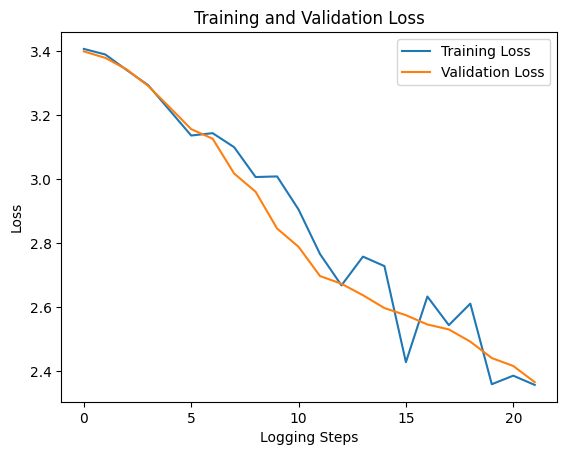

In [6]:
import matplotlib.pyplot as plt

# Extract loss values from the logs
train_losses = []
eval_losses = []
for log in trainer.state.log_history:
    if 'loss' in log:
        train_losses.append(log['loss'])
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])

# Plot the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Logging Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()